# Téléchargements des jeux de données


In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-classification-mri


In [11]:
!pip install --upgrade keras-hub
!pip install --upgrade keras-hub-nightly

In [12]:
!pip install tensorflow-hub  # Installs the tensorflow-hub package, which includes keras_hub
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
import tensorflow_hub as hub  # Imports tensorflow_hub and renames it to 'hub' for consistency
import numpy as np
import tensorflow_datasets as tfds

In [13]:
!mkdir -p ~/.kaggle
from google.colab import files

# Importer kaggle.json depuis votre PC
uploaded = files.upload()
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [14]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri


Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
brain-tumor-classification-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


# Décompression du fichier ZIP


In [15]:
!unzip brain-tumor-classification-mri.zip -d /content/tumeur_cerveau_data


Archive:  brain-tumor-classification-mri.zip
replace /content/tumeur_cerveau_data/Testing/glioma_tumor/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/tumeur_cerveau_data/Testing/glioma_tumor/image(1).jpg  
replace /content/tumeur_cerveau_data/Testing/glioma_tumor/image(10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/tumeur_cerveau_data/Testing/glioma_tumor/image(10).jpg  
replace /content/tumeur_cerveau_data/Testing/glioma_tumor/image(100).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/tumeur_cerveau_data/Testing/glioma_tumor/image(100).jpg  
replace /content/tumeur_cerveau_data/Testing/glioma_tumor/image(11).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/tumeur_cerveau_data/Testing/glioma_tumor/image(11).jpg  
replace /content/tumeur_cerveau_data/Testing/glioma_tumor/image(12).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/tumeur_cerveau_data/Testing/glioma_tumor/image(12).j

# Structure du Dataset




In [16]:
import os

data_dir = "/content/tumeur_cerveau_data/Training"

try:
    # Vérifier si le répertoire existe avant de l'utiliser
    if os.path.exists(data_dir):
        print(f"Le répertoire '{data_dir}' existe.")
        classes = os.listdir(data_dir)  # Lister les sous-dossiers
        print("Classes trouvées :", classes)
    else:
        print(f"Le répertoire '{data_dir}' n'existe pas. Vérifiez le chemin.")
except Exception as e:
    print(f"Erreur : {e}")


Le répertoire '/content/tumeur_cerveau_data/Training' existe.
Classes trouvées : ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


# Compter le nombre d'image par classe


In [17]:
# Calculer le nombre d'images dans chaque classe
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}
print("Répartition des classes :", class_counts)


Répartition des classes : {'glioma_tumor': 826, 'meningioma_tumor': 822, 'no_tumor': 395, 'pituitary_tumor': 827}


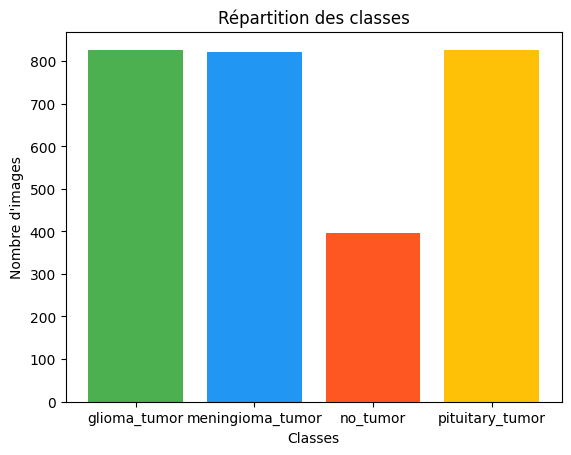

In [18]:
import matplotlib.pyplot as plt # Import the matplotlib library and assign it to the alias 'plt'

colors = ['#4CAF50', '#2196F3', '#FF5722', '#FFC107']  # Palette de couleurs
# Extract labels and values from the class_counts dictionary for the bar plot
labels = list(class_counts.keys())
values = list(class_counts.values())

plt.bar(labels, values, color=colors)
plt.xlabel("Classes")
plt.ylabel("Nombre d'images")
plt.title("Répartition des classes")
plt.show()

# Visualisation des images du dataset



Consulter des exemples d’IRM afin de mieux interpréter les données

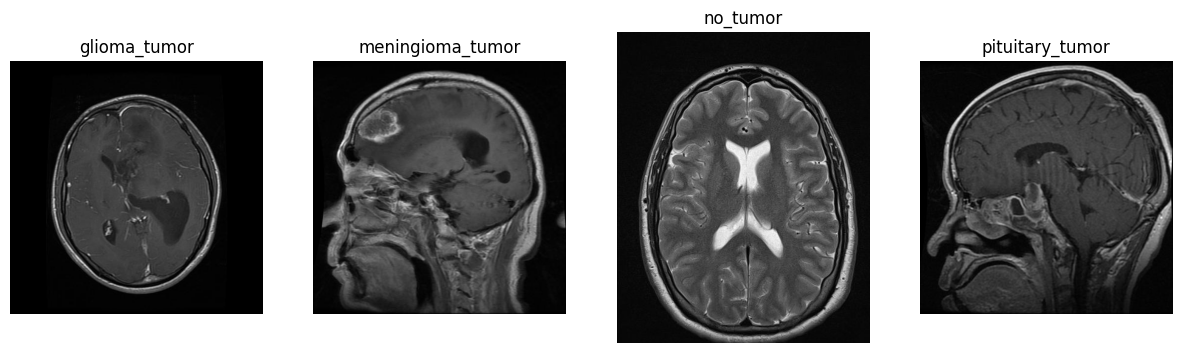

In [19]:
import random
import matplotlib.pyplot as plt
from PIL import Image
# Créer une figure avec 4 images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Parcourir les 4 premières classes et afficher une image aléatoire
for i, cls in enumerate(classes[:4]):
    img_files = os.listdir(os.path.join(data_dir, cls))
    img_path = os.path.join(data_dir, cls, random.choice(img_files))  # Choisir une image aléatoire
    img = Image.open(img_path)  # Ouvrir l'image
    axes[i].imshow(img)  # Afficher l'image
    axes[i].set_title(cls)  # Ajouter un titre (nom de la classe)
    axes[i].axis('off')  # Enlever les axes

plt.show()


# Chargement des images et création des ensembles d'entrainement et validation


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définir la taille des images et le batch size
img_size = (224, 224)  # Modifier la taille des images si nécessaire (par exemple, 128x128)
batch_size = 32

# Appliquer une normalisation aux images et séparer en ensemble d'entraînement/validation
# Ajout d'augmentations pour améliorer la robustesse du modèle
datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalisation des pixels des images
    rotation_range=40,  # Rotation aléatoire des images
    width_shift_range=0.2,  # Décalage horizontal
    height_shift_range=0.2,  # Décalage vertical
    shear_range=0.2,  # Cisaillement
    zoom_range=0.2,  # Zoom aléatoire
    horizontal_flip=True,  # Retourner les images horizontalement
    fill_mode='nearest',  # Remplir les pixels manquants
    validation_split=0.2  # 20% des images pour la validation
)
# Chargement des images pour l'entraînement
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,  # Ajuster la taille des images
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # 80% des images
)
# Chargement des images pour la validation
val_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,  # Ajuster la taille des images
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # 20% des images
)


Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


*   On redimensionne les images à 224x224 pixels.

*  On normalise les pixels pour qu’ils soient entre 0 et 1.

*  On divise les données en entraînement (80%) et validation (20%).

# Construction et création d'un modèle : modèle de classification basé sur EfficientNetB0



In [21]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Charger le modèle pré-entraîné EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # On ne réentraîne pas les couches de base

# Ajouter des couches personnalisées pour adapter le modèle à notre problème
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(classes), activation='softmax')(x)  # Softmax pour la classification multi-classe

# Définir le modèle final
model = Model(inputs=base_model.input, outputs=output)

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# Entrainement du modèle avec 10 époques

In [22]:
history = model.fit(
    train_data,  # Tes données d'entraînement
    validation_data=val_data,  # Tes données de validation
    epochs=10,  # Nombre d'époques
    verbose=1  # Affichage de la progression
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.2788 - loss: 1.4044 - val_accuracy: 0.2862 - val_loss: 1.3552
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 303s 4s/step - accuracy: 0.3038 - loss: 1.3660 - val_accuracy: 0.2862 - val_loss: 1.3534
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.2972 - loss: 1.3407 - val_accuracy: 0.2880 - val_loss: 1.3531
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 280s 4s/step - accuracy: 0.3031 - loss: 1.3505 - val_accuracy: 0.2880 - val_loss: 1.3505
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 288s 4s/step - accuracy: 0.2818 - loss: 1.3487 - val_accuracy: 0.2880 - val_loss: 1.3510
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.2995 - loss: 1.3411 - val_accuracy: 0.2880 - val_loss: 1.3501
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.2871 - loss: 1.3514 - val_accuracy: 0.2862 - val_loss: 1.3497
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.3044 - loss: 1.3512 - val_accuracy: 0.2862 - v

# Conserver ce modèle pour une utilisation future

In [23]:
import keras
keras.saving.save_model(model, "brain_tumor_model.keras")


# Affichage des courbes d'apprentissage


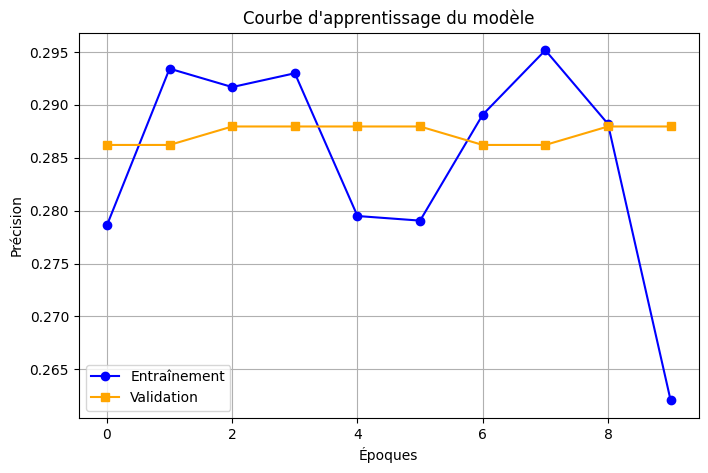

In [42]:
import matplotlib.pyplot as plt

# Définition du graphique
plt.figure(figsize=(8, 5))

# Affichage des courbes avec styles améliorés
plt.plot(history.history['accuracy'], label='Entraînement', color='blue', linestyle='-', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation', color='orange', linestyle='-', marker='s')

# Ajout des détails visuels
plt.xlabel("Époques")
plt.ylabel("Précision")
plt.title("Courbe d'apprentissage du modèle")
plt.legend()
plt.grid(True)

# Affichage
plt.show()


In [35]:
!ls /content/tumeur_cerveau_data/Training/

glioma_tumor  meningioma_tumor	no_tumor  pituitary_tumor


In [37]:
!ls -b /content/tumeur_cerveau_data/Training/glioma_tumor


gg\ (100).jpg  gg\ (250).jpg  gg\ (3).jpg    gg\ (54).jpg   gg\ (69).jpg
gg\ (101).jpg  gg\ (251).jpg  gg\ (400).jpg  gg\ (550).jpg  gg\ (6).jpg
gg\ (102).jpg  gg\ (252).jpg  gg\ (401).jpg  gg\ (551).jpg  gg\ (700).jpg
gg\ (103).jpg  gg\ (253).jpg  gg\ (402).jpg  gg\ (552).jpg  gg\ (701).jpg
gg\ (104).jpg  gg\ (254).jpg  gg\ (403).jpg  gg\ (553).jpg  gg\ (702).jpg
gg\ (105).jpg  gg\ (255).jpg  gg\ (404).jpg  gg\ (554).jpg  gg\ (703).jpg
gg\ (106).jpg  gg\ (256).jpg  gg\ (405).jpg  gg\ (555).jpg  gg\ (704).jpg
gg\ (107).jpg  gg\ (257).jpg  gg\ (406).jpg  gg\ (556).jpg  gg\ (705).jpg
gg\ (108).jpg  gg\ (258).jpg  gg\ (407).jpg  gg\ (557).jpg  gg\ (706).jpg
gg\ (109).jpg  gg\ (259).jpg  gg\ (408).jpg  gg\ (558).jpg  gg\ (707).jpg
gg\ (10).jpg   gg\ (25).jpg   gg\ (409).jpg  gg\ (559).jpg  gg\ (708).jpg
gg\ (110).jpg  gg\ (260).jpg  gg\ (40).jpg   gg\ (55).jpg   gg\ (709).jpg
gg\ (111).jpg  gg\ (261).jpg  gg\ (410).jpg  gg\ (560).jpg  gg\ (70).jpg
gg\ (112).jpg  gg\ (262).jpg  gg\ (411).jp

# Vérifier si l’IA prédit correctement sur une image inconnue.


In [40]:
import glob

# Cherche tous les fichiers qui contiennent "(102)"
files = glob.glob("/content/tumeur_cerveau_data/Training/glioma_tumor/*(102)*")

if files:
    print("Fichier trouvé :", files[0])
else:
    print("Fichier non trouvé.")


Fichier trouvé : /content/tumeur_cerveau_data/Training/glioma_tumor/gg (102).jpg


# Visualisation de la prédiction

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


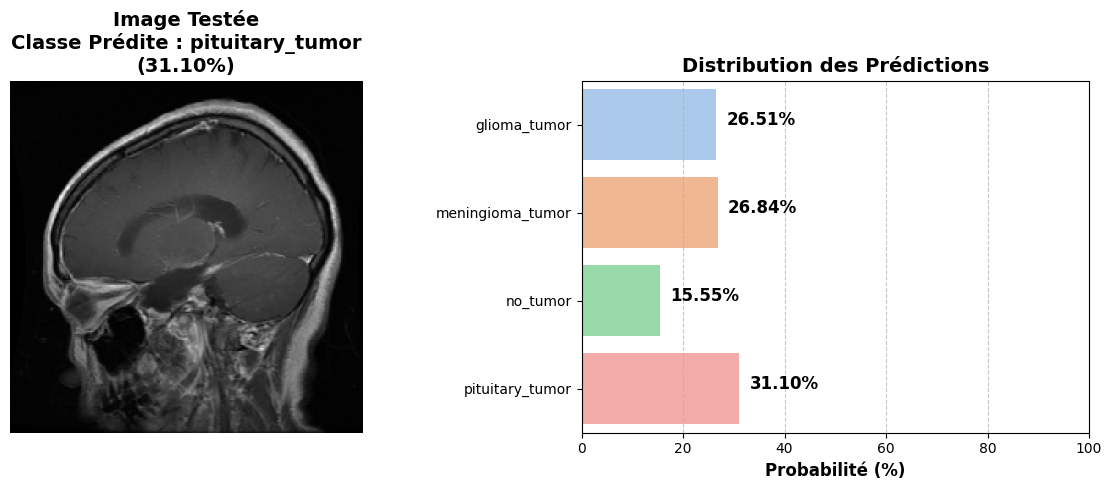

In [41]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing import image

# Cherche l'image qui contient (102)
files = glob.glob("/content/tumeur_cerveau_data/Training/glioma_tumor/*(102)*")

if not files:
    print("Image non trouvée !")
else:
    img_path = files[0]

    # Charger et prétraiter l'image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

    # Faire la prédiction
    prediction = model.predict(img_array)
    predicted_class = classes[np.argmax(prediction)]
    predicted_prob = np.max(prediction) * 100

    # Afficher résultats
    plt.figure(figsize=(12, 5))

    # Image
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image Testée\nClasse Prédite : {predicted_class}\n({predicted_prob:.2f}%)", fontsize=14, fontweight="bold")
    plt.axis("off")

    # Barplot des prédictions
    plt.subplot(1, 2, 2)
    colors = sns.color_palette("pastel", len(classes))
    sns.barplot(x=prediction[0] * 100, y=classes, hue=classes, palette=colors, legend=False)

    for index, value in enumerate(prediction[0] * 100):
        plt.text(value + 2, index, f"{value:.2f}%", fontsize=12, fontweight="bold", color="black")

    plt.xlabel("Probabilité (%)", fontsize=12, fontweight="bold")
    plt.title("Distribution des Prédictions", fontsize=14, fontweight="bold")
    plt.xlim(0, 100)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
